Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [98]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import Augmentor
from glob import glob
import os
import PIL
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [28]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [89]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./data/Train")
data_dir_test = pathlib.Path('./data/Test')

In [90]:
data_dir_train

PosixPath('data/Train')

In [91]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [22]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [23]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Create training dataset
seed_count = 123
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=seed_count,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [24]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Create validation dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=seed_count,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [25]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2024-06-11 10:46:26.891071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


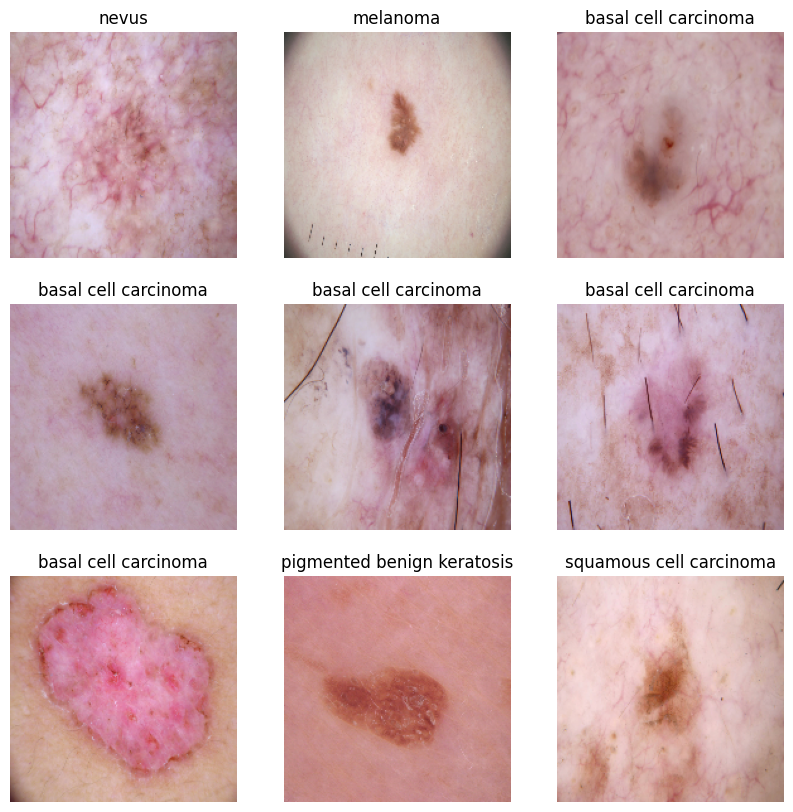

In [26]:
# Configure the dataset for performance 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Print a sample from the dataset

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [31]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00013116575 0.9946274


In [34]:
first_image.shape

TensorShape([180, 180, 3])

In [33]:
len(image_batch)

32

In [42]:
### Your code goes here
num_classes = 9

model = Sequential([
    #rescaling layer
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #first conv layer
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),

  #second conv layer
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),

  #third conv layer
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),

  #Dropout layer
  layers.Dropout(0.5),

  #flatten layer
  layers.Flatten(),

  #dense layer
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),

  #Dropout layer with 25% Fraction of the input units to drop.
  layers.Dropout(0.25),

  #Dense Layer with softmax activation function.
  layers.Dense(len(class_names),activation='softmax')

])

In [43]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 9)              │         1,161 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,763 (12.60 MB)

 Trainable params: 3,301,763 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

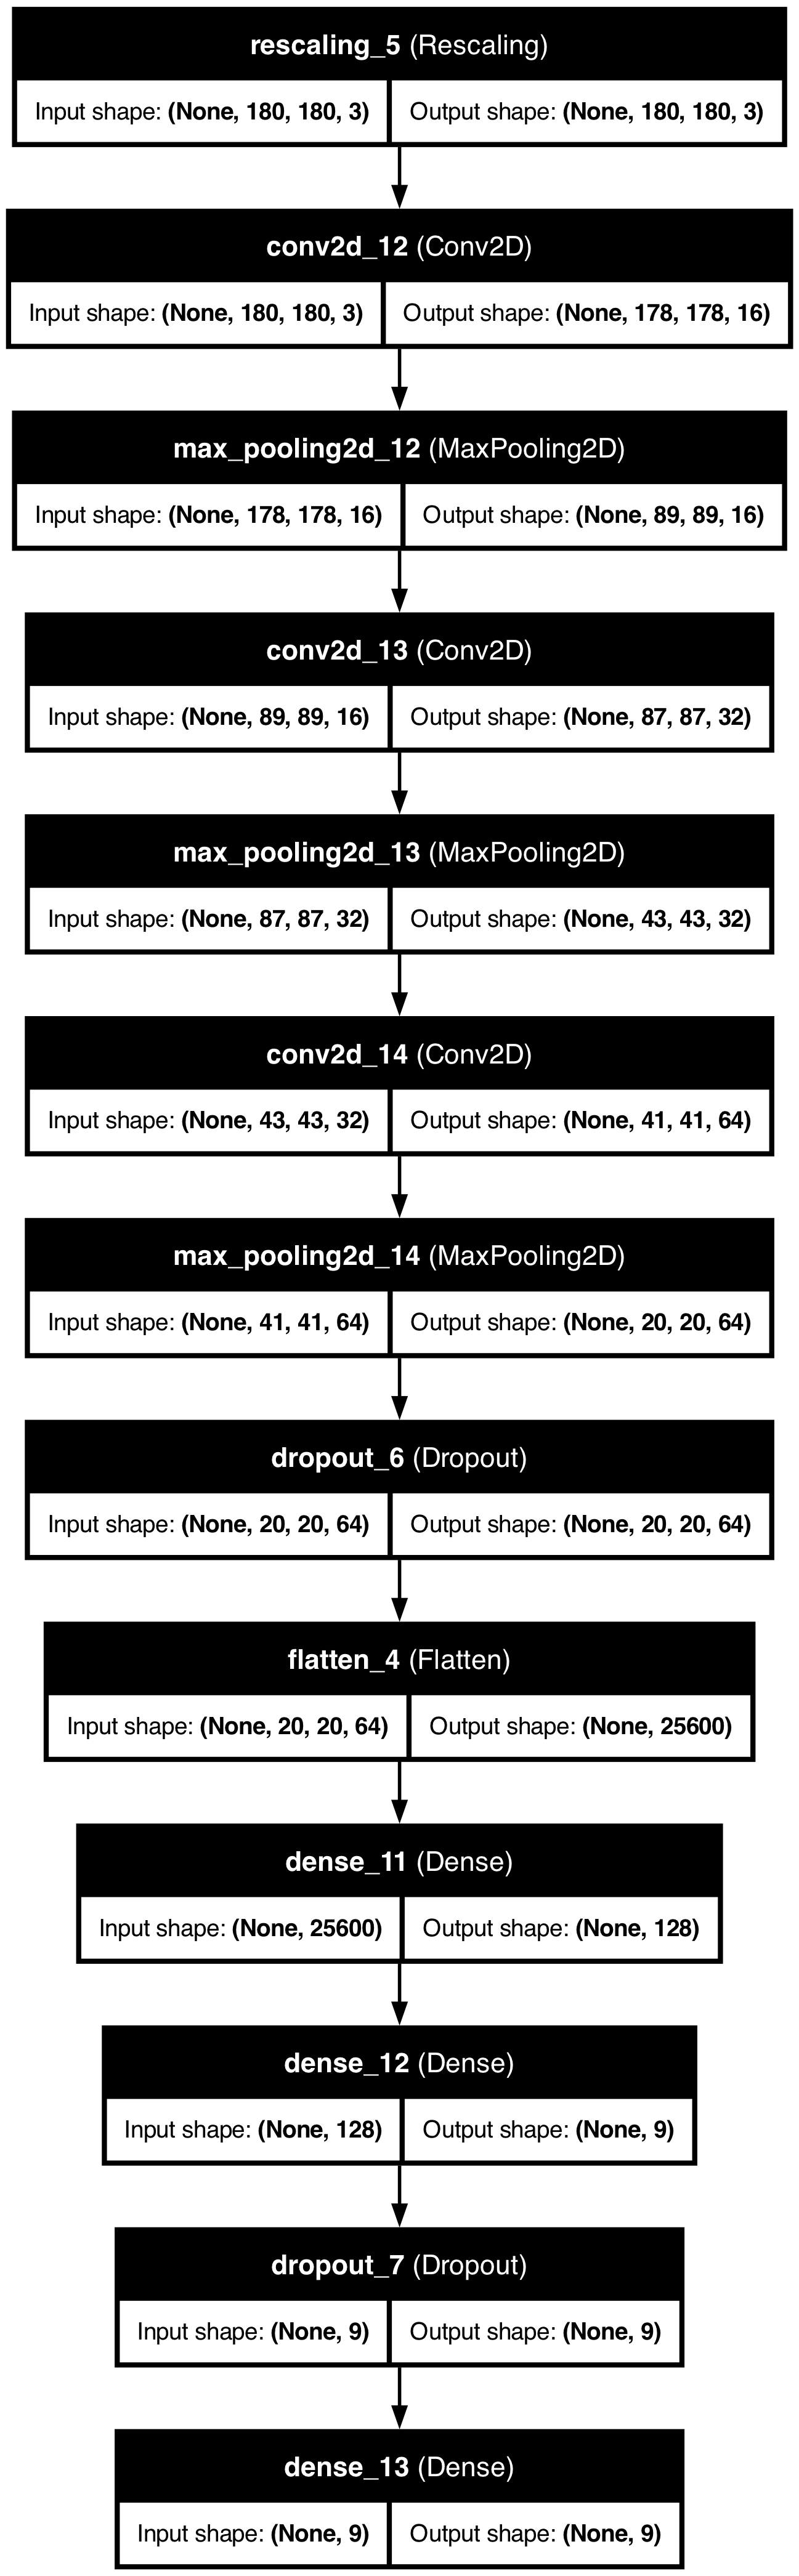

In [46]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [64]:
def compile_model():
    ### Todo, choose an appropirate optimiser and loss function
    model.compile(optimizer='Adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
    checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

compile_model()

### Train the model

In [52]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.1860 - loss: 2.2909 - val_accuracy: 0.2752 - val_loss: 1.9831
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.2114 - loss: 2.0298 - val_accuracy: 0.3110 - val_loss: 1.8520
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.3395 - loss: 1.8297 - val_accuracy: 0.4318 - val_loss: 1.6391
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.3686 - loss: 1.6917 - val_accuracy: 0.4855 - val_loss: 1.5767
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.4450 - loss: 1.5694 - val_accuracy: 0.5257 - val_loss: 1.4345
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.4647 - loss: 1.5060 - val_accuracy: 0.5078 - val_loss: 1.4352
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.4921 - loss: 1.4211 - val_accuracy: 0.5257 - val_loss: 1.3839
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.5106 - loss: 1.4234 - val_accuracy: 0.

### Visualizing training results

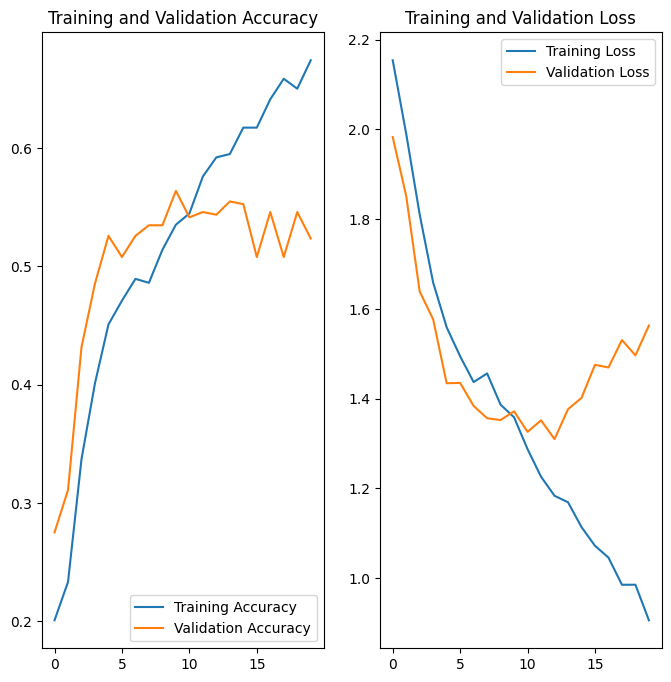

In [63]:
def plot_acc_loss(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_acc_loss(history, epochs)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

At Epoch 10 we notice that the Validation acuracy does not increase any more while Training accuracy keeps on increasing till Epoch 20. On the loss graoh we see that Validation loss in fact starts to increase after Epoch 10. This shows that the model is overfitting. 

In [54]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

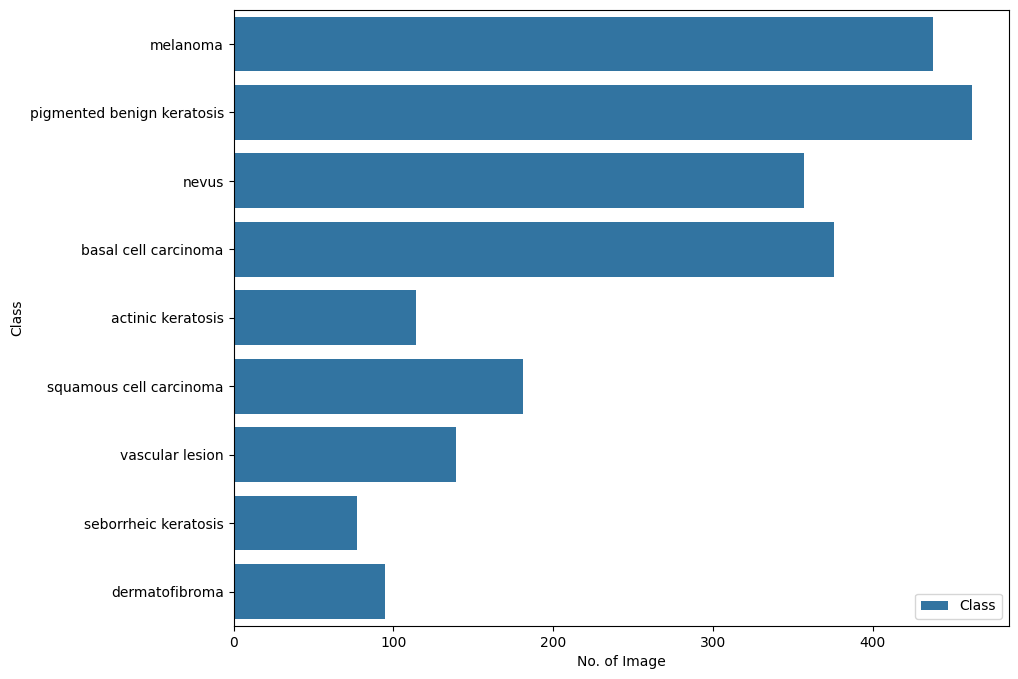

In [56]:
#Visualize the Number of image in each class.

plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

Seborrheic keratosis class has the least number of samples.
Classes 'pigmented benign keratosis' , 'melona', 'nevus' and 'basal cell carinoma' dominate the dataset


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [76]:
fail_count = 0
for i in class_names:
    p = Augmentor.Pipeline("./data/Train")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    try:
        p.sample(500)
    except Exception as e:
        fail_count += 1 
        print(f"Augmentation failed for: {e}")
    
print(fail_count)

Initialised with 2239 image(s) found.
Output directory set to ./data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x322035880>: 100%|██████████| 500/500 [00:03<00:00, 161.73 Samples/s]                    


Initialised with 2239 image(s) found.
Output directory set to ./data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3C720BB60>: 100%|██████████| 500/500 [00:02<00:00, 167.56 Samples/s]                    


Initialised with 2239 image(s) found.
Output directory set to ./data/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x322085FA0>: 100%|██████████| 500/500 [00:02<00:00, 168.05 Samples/s]  


Initialised with 2239 image(s) found.
Output directory set to ./data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x316DB2C60>: 100%|██████████| 500/500 [00:03<00:00, 162.81 Samples/s]                   


Initialised with 2239 image(s) found.
Output directory set to ./data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3C51428A0>: 100%|██████████| 500/500 [00:03<00:00, 147.39 Samples/s]                    


Initialised with 2239 image(s) found.
Output directory set to ./data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x321FCB080>: 100%|██████████| 500/500 [00:03<00:00, 156.01 Samples/s]                   


Initialised with 2239 image(s) found.
Output directory set to ./data/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x322027260>: 100%|██████████| 500/500 [00:03<00:00, 135.19 Samples/s]  


Initialised with 2239 image(s) found.
Output directory set to ./data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3C4CFFB90>: 100%|██████████| 500/500 [00:03<00:00, 152.69 Samples/s]                    


Initialised with 2239 image(s) found.
Output directory set to ./data/Train/output.

Processing <PIL.Image.Image image mode=RGB size=724x542 at 0x3C4C28CB0>: 100%|██████████| 500/500 [00:03<00:00, 143.73 Samples/s]                    

0


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Moved the augmented images from output folder to the respective class folder. then deleted the output folder so that the number of calsses remain the same 

#### **Todo**: Train the model on the data created using Augmentor

In [137]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [138]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [139]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [140]:
## your code goes here
### Your code goes here
num_classes = 9

model = Sequential([
    #rescaling layer
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #first conv layer
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),

  #second conv layer
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),

  #third conv layer
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),

  #Dropout layer
  layers.Dropout(0.5),

  #flatten layer
  layers.Flatten(),

  #dense layer
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),

  #Dropout layer with 25% Fraction of the input units to drop.
  layers.Dropout(0.25),

  #Dense Layer with softmax activation function.
  layers.Dense(len(class_names),activation='softmax')

])

In [141]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 9)              │         1,161 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 9)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,763 (12.60 MB)

 Trainable params: 3,301,763 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [142]:
## your code goes here
def compile_model():
    ### Todo, choose an appropirate optimiser and loss function
    model.compile(optimizer='Adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
    checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

compile_model()

#### **Todo:**  Train your model

In [143]:
class_names = train_ds.class_names
print("Class names:", class_names)
print("Number of classes:", len(class_names))

Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of classes: 9


In [ ]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### **Todo:**  Visualize the model results

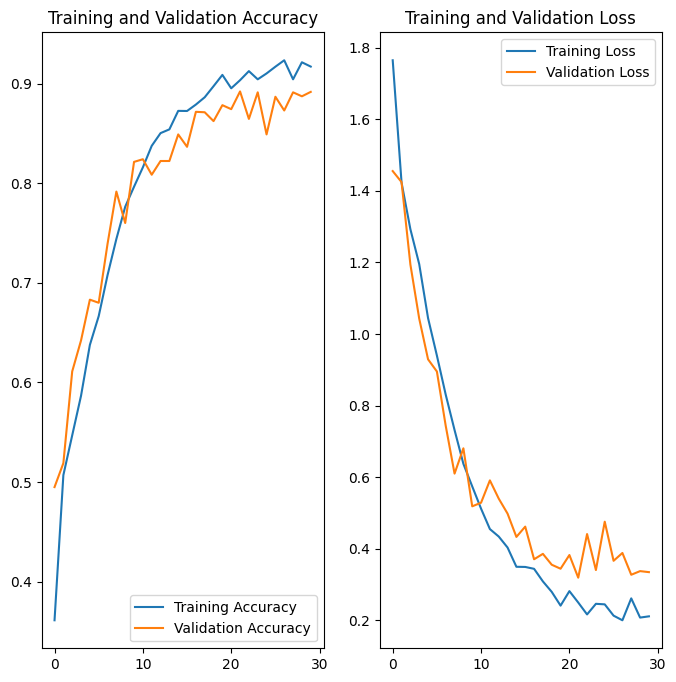

In [145]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Now we can see that Accuracy for the training and validation sets are progressing with similiar trends. The loss also is decreasing on both sets. Thsi shows that with class rebalance helped gettign a better model.

# Model Evaluation

In [146]:
# Load the test dataset
test_ds = image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Do not shuffle to keep the order of images
)

Found 118 files belonging to 9 classes.


In [153]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.023324754 0.76393884


In [154]:
# Evaluate the model on the test dataset
results = model.evaluate(test_ds)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1875 - loss: 5.2509

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.2718 - loss: 7.5267


In [155]:
# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

Test Loss: 7.51218318939209
Test Accuracy: 0.3305084705352783


In [156]:
# Optionally, get predictions and compare with true labels for further analysis
predictions = model.predict(test_ds)
predicted_classes = tf.argmax(predictions, axis=1)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


In [157]:
# Get true labels from the dataset
true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())

# Convert to TensorFlow tensor
true_labels = tf.constant(true_labels, dtype=tf.int64)
# Ensure predicted classes are the same data type as true labels
predicted_classes = tf.cast(predicted_classes, dtype=tf.int64)

# Calculate overall accuracy (should match the output from model.evaluate)
accuracy = tf.reduce_mean(tf.cast(predicted_classes == true_labels, tf.float32)).numpy()
print("Calculated Accuracy:", accuracy)

Calculated Accuracy: 0.33050847


2024-06-12 16:23:10.272459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
